In [1]:
%load_ext autoreload
%autoreload 2
import pickle
from MARBLE import utils, plotting, net, preprocessing, postprocessing, geometry

import matplotlib.pyplot as plt

# Visualise a single condition in a single session

In [18]:
#pos, vel, time, cond_labels = pickle.load(open('../outputs/spiking_data/raw_data_session_1.pkl','rb'))

data = []
for i in range(2):
    data.append(pickle.load(open('../outputs/spiking_data/data_object_session_{}.pkl'.format(i),'rb')))

In [3]:
from torch_geometric.data import Batch
from torch_geometric.transforms import RandomNodeSplit
batch = Batch.from_data_list(data, exclude_keys=['L','gauges','dist','gamma', 'manifold', 'emb','clusters'])
split = RandomNodeSplit(split='train_rest', num_val=0.1, num_test=0.1)
split(batch)
    
batch = preprocessing(batch, vector=False, compute_laplacian=False, n_evec=128)

---- Embedding dimension: 5
---- Signal dimension: 5

Vector computations are disabled

---- Computing kernels ... Done 
---- Computing eigendecomposition ... Done 


# Train model on all conditions and sessions

In [5]:
par = {'epochs': 150, #optimisation epochs
       'order': 2, #order of derivatives
       'hidden_channels': 32, #number of internal dimensions in MLP
       'out_channels': 8,
       'inner_product_features': False,
       'diffusion': False,
      }
    
model = net(batch, par=par)
    
model.run_training(batch, use_best=True, outdir='../outputs/spiking_data/all_sessions') 


---- Settings: 

epochs : 150
order : 2
hidden_channels : 32
out_channels : 8
inner_product_features : False
diffusion : False
batch_size : 64
lr : 0.01
momentum : 0.9
include_positions : False
frac_sampled_nb : -1
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 5
dim_emb : 5
n_sampled_nb : -1

---- Number of features to pass to the MLP:  155
---- Total number of parameters:  5257

---- Training network ...

Epoch: 1, Training loss: 1.3827, Validation loss: 1.3802, lr: 0.0100 *
Epoch: 2, Training loss: 1.3642, Validation loss: 1.3233, lr: 0.0100 *
Epoch: 3, Training loss: 1.2990, Validation loss: 1.2707, lr: 0.0100 *
Epoch: 4, Training loss: 1.2504, Validation loss: 1.2671, lr: 0.0100 *
Epoch: 5, Training loss: 1.2310, Validation loss: 1.2468, lr: 0.0100 *
Epoch: 6, Training loss: 1.2060, Validation loss: 1.2173, lr: 0.0100 *
Epoch: 7, Training loss: 1.2044, Validation loss: 1.2218, lr: 0.0100
Epoch: 8, Training loss: 1

In [19]:
batch = model.evaluate(batch)
batch = postprocessing(batch)

RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/site-packages/ot/lp/__init__.py:547: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


Performed umap embedding on embedded results.


In [15]:
batch

DataBatch(x=[21624, 5], edge_index=[2, 598004], y=[21624], pos=[21624, 5], edge_weight=[598004], num_nodes=21624, num_node_features=[14], sample_ind=[21624], batch=[21624], degree=[2], number_of_resamples=[2], train_mask=[21624], val_mask=[21624], test_mask=[21624], kernels=[5], local_gauges=False, time=[2], out=[21624, 8], gauges=[21624, 5, 5], emb=[21624, 2], dist=[2, 2], manifold=UMAP(random_state=0, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}))

In [ ]:
conditions = ['DownLeft','Left','UpLeft','Up','UpRight','Right','DownRight']
plotting.embedding(batch, data.y.numpy().astype(int), titles=conditions)

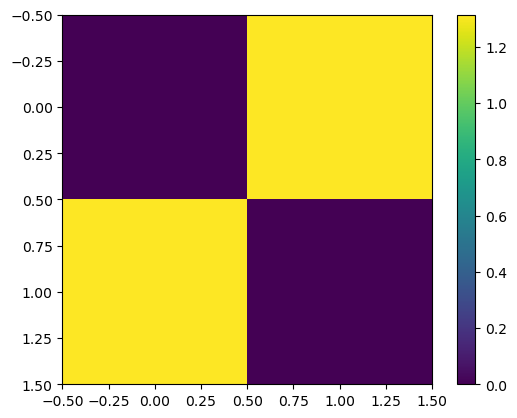

In [17]:
plt.imshow(batch.dist); plt.colorbar()  

In [ ]:
emb_MDS, _ = geometry.embed(batch.dist, embed_typ = 'MDS')
labels = [i for i in range(len(conditions))]
plotting.embedding(emb_MDS, labels, titles=conditions, s=30, alpha=1)

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
rates = pickle.load(open('../outputs/spiking_data/rate_data_1ms.pkl','rb'))       

# definingf the set of conditions     
conditions=['DownLeft','Left','UpLeft','Up','UpRight','Right','DownRight']    
    
# list of days
days = rates.keys()
    
# define some parameters
pca_n = 5
      
# storing all distance matrices
embeddings = []
distance_matrices = []
    

times = [];
all_condition_labels = [];
    
# loop over each day
for day in days:
        
        # first stack all trials from that day together and fit pca
        print(day)
        pos = []            
        # loop over each condition on that day
        for c, cond in enumerate(conditions):

            # go cue at 500ms
            data = rates[day][cond][:,500:,:]
            
            # loop over all trials
            for trial in data:
                # store each trial as time x channels
                pos.append(trial)
              
        # stacking all trials into a single array (time x channels)
        pos = np.vstack(pos)
        print(pos.shape)
        
        # fit PCA to all data across all conditions on a given day simultaneously
        pca = PCA(n_components=pca_n)
        pca.fit(pos)     
        print(pca.explained_variance_ratio_)  

In [ ]:
rates[day][cond].shape